# MATH 6397 - Computational Challenge 2
    
## Quasi-stationary distributions in the birth-death model
    
    
**Group 2:** Thuyen (presenter), Danial, Manoj and Daniel.

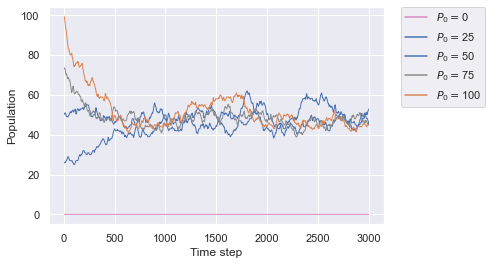

Computational time is 2.676429271697998 seconds.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from numba import jit
import seaborn as sns
sns.set()


# sns.set(style="whitegrid")


# Function: Change of Population
@jit(nopython=True)
def changePop(b, d):
    s = np.random.random_sample()
    if s < b:
        return 1
    elif s > (b+d):
        return 0
    else:
        return -1


# Function: Find Probability of Birth/Dearth/None
@jit(nopython=True)
def findProp(currentpop,r,K):
    b = r*(currentpop - np.power(currentpop, 2)/(2*K))
    d = r*np.power(currentpop, 2)/(2*K)
    return b, d


# Function: Generate One Population Trajectory
@jit(nopython=True)
def popTrajectory(endtime,r,K,initpop):
    pop = np.zeros(t)
    pop[0] = initpop
    for k in range(endtime-1):
        if pop[k] < 1:
            break
        else:
            b, d = findProp(pop[k],r,K)
            pop[k+1] = pop[k] + changePop(b, d)
    return pop


# Generate and plot some population trajectories
# --- Intial Parameters
r = 0.004 
K = 50     # Maximum population size (capacity) is 2K
t = 3000   # End time


aP0 = [0, 25, 50, 75, 100]  # Initial population


start2 = time.time()

#--- Plot
current_palette = sns.color_palette()
for P0 in aP0:
    pop = popTrajectory(t, r, K, P0)
    tm = np.linspace(0, t-1, t)
    time_pop = pd.DataFrame(pop, tm, ['$P_0=$%g'%(P0)])
    time_pop = time_pop.rolling(7).mean()
    ax = sns.lineplot(data=time_pop, palette=[current_palette[np.random.randint(0,len(current_palette))]], linewidth=1)

ax.set(xlabel='Time step', ylabel='Population')
# plt.legend(loc='upper right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

fig = ax.get_figure()
fig.savefig("1-1-PopulationTrajectories.png") 

end2 = time.time()

print('Computational time is {t} seconds.'.format(t=end2-start2))

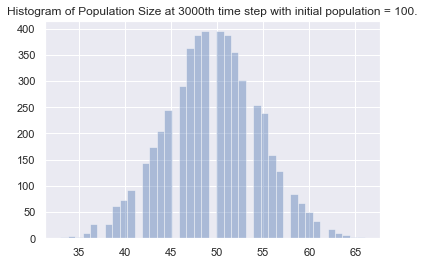

Computational time is 1.110105276107788 seconds.


In [2]:
#--- Histogram of population time at t=3000
N_trial = 5000
initpop = 100

start1 = time.time()

s = []
for i in range(N_trial):
    pop = popTrajectory(t, r, K, initpop)
    s.append(pop[t-1])

pop_hist = sns.distplot(s, kde=False)
plt.title('Histogram of Population Size at {T}th time step with initial population = {P}.'.format(T=t,P=P0))
# plt.legend(loc="upper left")
plt.show()

fig = pop_hist.get_figure()
fig.savefig("1-2-Histogram.png") 

end1 = time.time()

print('Computational time is {t} seconds.'.format(t=end1-start1))

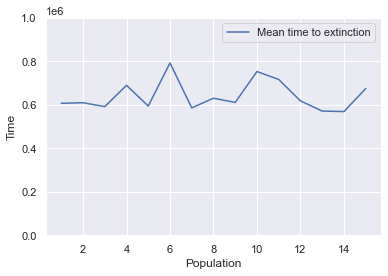

Computational time is 42.92005276679993 seconds.


In [3]:
# Find the extinction time
#--- Intial Parameters

r1 = 0.015
K1 = 8


# Function: Extinction time
@jit(nopython=True)
def extinctionTime(pop,r1,K1):
    extime = 0
    while pop > 0:
        extime += 1
        b, d = findProp(pop,r1,K1)
        pop += changePop(b, d)
    return extime


start = time.time()

p0 = np.arange(1,2*K1) # generate the initial population vector
lp0 = len(p0)

ntrial = 100 # number of simulation for each element of p0

mean_extime = np.zeros(lp0)
for i in range(lp0):
    aextime = np.zeros(ntrial)
    for j in range(ntrial):
        aextime[j] = extinctionTime(p0[i],r1,K1)
    
    mean_extime[i] = np.mean(aextime)

end = time.time()

pop_meanex = pd.DataFrame(mean_extime,p0,['Mean time to extinction'])
plot_meanex = sns.lineplot(data=pop_meanex)

plot_meanex.set(xlabel='Population', ylabel='Time')
plot_meanex.set(ylim=(0, 1000000))
plt.show()

fig = plot_meanex.get_figure()
fig.savefig("2-2-ExtinctionTime.png") 

print('Computational time is {t} seconds.'.format(t=end-start))

In [ ]:
#--- Histogram of population time at t1=900000
N_trial1 = 500
P = 5
t = 9000


start3 = time.time()

s = []
for i in range(N_trial1):
    pop = popTrajectory(t, r1, K1, P)
    s.append(pop[t-1])

pop1_hist = sns.distplot(s, kde=False)
plt.title('Histogram of Population Size at {T}th time step with initial population = {P}.'.format(T=t,P=P))
# plt.legend(loc="upper left")
plt.show()

fig = pop1_hist.get_figure()
fig.savefig("2-1-Histogram.png") 

end3 = time.time()

print('Computational time is {sec} seconds.'.format(sec=end3-start3))